In [1]:
import numpy as np

import datasets
import utils

from ela import generator, random

predictions = utils.TestPredictions('nopoolrefinenet_dpn92', mode='val').load_raw()
gen = utils.mask_stratified_k_fold(5)
next(gen)
samples = next(gen)[1]
transforms = generator.TransformationsGenerator([])
dataset = datasets.AnalysisDataset(samples, './data/train', transforms, predictions)

Sorting train samples:   5%|▌         | 213/4000 [00:00<00:01, 2121.41it/s]

0 1.00e-02
1 9.80e-03
2 9.60e-03
3 9.40e-03
4 9.20e-03
5 9.00e-03
6 8.80e-03
7 8.60e-03
8 8.40e-03
9 8.20e-03
10 8.00e-03
11 7.80e-03
12 7.60e-03
13 7.40e-03
14 7.20e-03
15 7.00e-03
16 6.80e-03
17 6.60e-03
18 6.40e-03
19 6.20e-03
20 6.00e-03
21 5.80e-03
22 5.60e-03
23 5.40e-03
24 5.20e-03
25 5.00e-03
26 4.80e-03
27 4.60e-03
28 4.40e-03
29 4.20e-03
30 4.00e-03
31 3.80e-03
32 3.60e-03
33 3.40e-03
34 3.20e-03
35 3.00e-03
36 2.80e-03
37 2.60e-03
38 2.40e-03
39 2.20e-03
40 2.00e-03
41 1.80e-03
42 1.60e-03
43 1.40e-03
44 1.20e-03
45 1.00e-03
46 8.00e-04
47 6.00e-04
48 4.00e-04
49 2.00e-04


Sorting train samples: 100%|██████████| 4000/4000 [00:01<00:00, 2179.95it/s]


In [2]:
import torch
from tqdm import tqdm
from metrics import mAP

data = []


for i in tqdm(range(len(dataset))):   
    prediction, target, id = dataset[i]
    
    prediction = torch.FloatTensor(prediction).unsqueeze(0)
    prediction = torch.sigmoid(prediction)
    prediction = torch.mean(prediction, dim=1)

    target = torch.FloatTensor(target).unsqueeze(0).unsqueeze(0)
    score = mAP(prediction > 0.5, target).item()
    
    data.append((id, prediction, target, score))


100%|██████████| 800/800 [00:21<00:00, 37.45it/s]


In [3]:
mean_score = []
for id, prediction, target, score in data:  
    mean_score.append(score)
    
print(np.mean(np.array(mean_score)))

0.8606249989662319


In [4]:
data = sorted(data, key=lambda x: x[3])

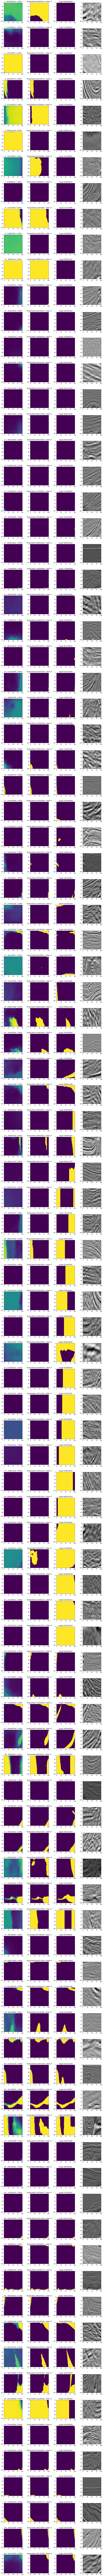

In [5]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import img_as_float
from skimage.io import imread
from skimage.measure import label

rows = 100
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
for i, (id, prediction, target, score) in enumerate(data[:rows]):
    prediction = prediction.squeeze()
    target = target.squeeze()
    
    ax[i][0].imshow(prediction, vmin = 0, vmax = 1)
    ax[i][0].set_title('{}:, {}: {:6.4f}'.format(i, id, score))
    ax[i][1].imshow((prediction > 0.5))
    ax[i][1].set_title('thresholded {} - blobs={}'.format(id, len(np.unique(label((prediction > 0.5).numpy())))))
    ax[i][2].imshow(target)
    ax[i][2].set_title('target {}'.format(id))
    
    ax[i][3].imshow(img_as_float(imread(join('./data/train', 'images', id) + '.png')))
    
    
plt.tight_layout()

NameError: name 'buckets_area' is not defined

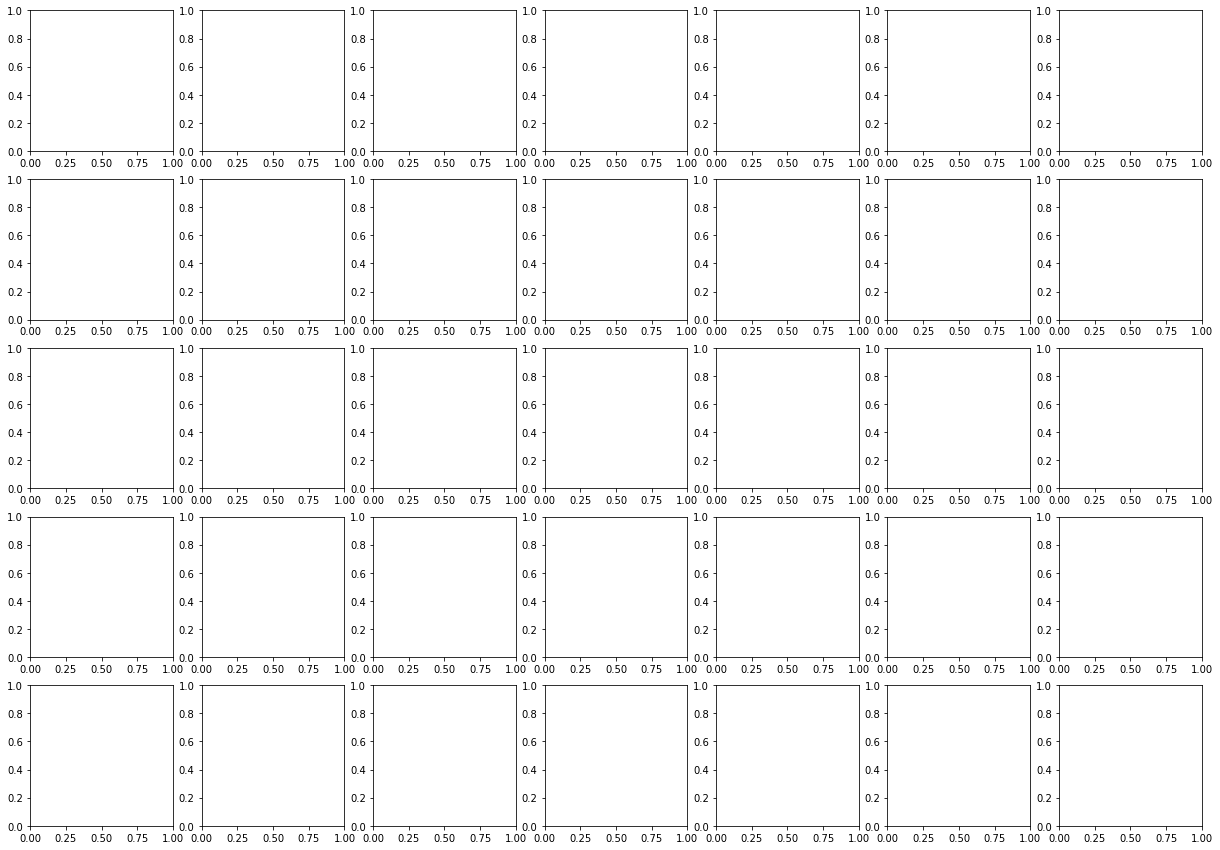

In [6]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.nn import functional as F

from skimage import img_as_float
from skimage.io import imread

rows = 5
cols = 7
fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
for i, (id, prediction, target, score) in zip(range(rows), buckets_area[0.1]):
    im = ax[i][0].imshow(prediction, vmin = 0, vmax = 1)
    ax[i][0].imshow(target)
    ax[i][0].set_title('mask {}'.format(id))
    
    target_t = torch.from_numpy(target)
    target_t_pooled = F.avg_pool2d(target_t.unsqueeze(0).unsqueeze(0), 8).squeeze()
    target_pooled_avg = target_t_pooled.numpy()
    ax[i][1].imshow(target_pooled_avg)
    ax[i][1].set_title('avg {}'.format(id))
    
    target_t = torch.from_numpy(target)
    target_t_pooled = F.interpolate(target_t.unsqueeze(0).unsqueeze(0), scale_factor=1/8, mode='bilinear', align_corners=False).squeeze()
    target_pooled_align_false = target_t_pooled.numpy()    
    ax[i][2].imshow(target_pooled_align_false)
    ax[i][2].set_title('align_false {}'.format(id))
    
    
    target_t = torch.from_numpy(target)
    target_t_pooled = F.interpolate(target_t.unsqueeze(0).unsqueeze(0), scale_factor=1/8, mode='bilinear', align_corners=True).squeeze()
    target_pooled_align_true = target_t_pooled.numpy()    
    ax[i][3].imshow(target_pooled_align_true)
    ax[i][3].set_title('align_true {}'.format(id))
    
    ax[i][4].imshow((target_pooled_align_false + target_pooled_avg) / 0.5)
    ax[i][4].set_title('align_false {}'.format(id))
    
    ax[i][5].imshow((target_pooled_align_true + target_pooled_avg) / 0.5)
    ax[i][5].set_title('align_true {}'.format(id))
    
    overlay = np.repeat(np.expand_dims(0.5*target, axis=2), 3, axis=2)
    overlay[:, :, [0, 1]] = 0
    ax[i][6].imshow(np.clip(overlay + img_as_float(imread(join('./data/train', 'images', id) + '.png')), 0, 1))
    ax[i][6].set_title('image {}'.format(id))    
    fig.colorbar(im, orientation='vertical', ax=ax[i][0])
    
plt.tight_layout()